## Introduction

In manufacturing, keeping high-quality standards is essential. Manual quality inspection methods can be slow, costly, and sometimes unreliable due to human error. By using artificial intelligence (AI), we have the chance to automate these processes, improving speed, accuracy, and efficiency. In this project, we aim to create a deep learning model using convolutional neural networks (CNNs) to automatically detect defects in submersible pump impellers.

At this stage of the project, we will focus on the steps needed to prepare the data, train different models, and choose the one that best meets our goal of accurate defect detection. This phase includes data preprocessing, model training, and evaluation to ensure the selected model works effectively for quality control.

## Objectives

### 1. Preprocessing (THE Progress done during Data Wrangling and EDA will now be tested)
- Apply transformations like resizing, normalization, and augmentation to ensure the dataset is well-prepared for training.
- Balance the dataset through data augmentation techniques, ensuring the model learns effectively from both defective and OK parts.

### 2. Training and Model Development
- Build two to three models to predict whether a part is defective or OK.
- Use convolutional neural networks (CNNs) designed for image classification and experiment with different architectures.
- Fine-tune the hyperparameters of the models to improve accuracy.

### 3. Evaluation and Model Selection
- Train the models on the dataset while ensuring proper data splitting between training and test sets to avoid overfitting.
- Evaluate each model’s performance using accuracy, precision, recall, and F1 score to determine which model works best.
- Choose the best-performing model based on these metrics and apply any necessary adjustments to improve its performance.

## Import the Libraries

In [18]:
# Basic Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn Libraries
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# TensorFlow / Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model



# Hyper parameter tunning
import keras_tuner as kt

#Other libraries
import cv2

## Splitting the Data in Training and Testing 

All the pictures are Already Augmented and Standarized in a 300x300 pixel format.
This was done during previous EDA and Data Wrangling step, so I will pull directly the pictures and split in Testing and Training.



In [3]:
#Upload the pictures by selecting the Paths to the training and testing directories
train_dir = "Pictures/train"
test_dir = "Pictures/test"

# Image Data Generator for normalization of images to [0, 1] range
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# Load training data with image size originally of 300x300
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'  # For binary classification (defective vs OK)
)

# Load testing data with the same image size
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)


Found 7487 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


Let's review the details on the classes to double check it matches the augmented and standarized data of EDA phase.


In [4]:
# Print the class indices
print("Class indices (mapping of labels):", train_generator.class_indices)

# Count the number of images in each class for training data
train_class_counts = {class_name: 0 for class_name in train_generator.class_indices.keys()}
for class_name, class_index in train_generator.class_indices.items():
    train_class_counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))

print("\nTraining class distribution:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

# Count the number of images in each class for test data
test_class_counts = {class_name: 0 for class_name in test_generator.class_indices.keys()}
for class_name, class_index in test_generator.class_indices.items():
    test_class_counts[class_name] = len(os.listdir(os.path.join(test_dir, class_name)))

print("\nTest class distribution:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")

Class indices (mapping of labels): {'def_front': 0, 'ok_front': 1}

Training class distribution:
def_front: 3758 images
ok_front: 3729 images

Test class distribution:
def_front: 453 images
ok_front: 262 images


## First CNN Model Creation

In [5]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

## Visualize the Model Created

In [14]:
#!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [16]:
#!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


In [17]:
# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Neural Network Architecture Description:

* Input Layer (300x300x3): The input layer accepts images of size 300x300 pixels with 3 channels (RGB), which is the standard input shape for our model.
* Conv2D Layer (32 filters, 3x3): The first convolutional layer applies 32 filters of size 3x3 to extract key features from the input image. It uses ReLU as the activation function to introduce non-linearity into the model.
* MaxPooling2D Layer (2x2): A max-pooling layer follows to downsample the feature maps, reducing their dimensions while preserving important information. This pooling layer uses a 2x2 window.
* Conv2D Layer (64 filters, 3x3): The second convolutional layer increases the number of filters to 64, again using a 3x3 kernel, allowing the model to capture more complex features from the image.
* MaxPooling2D Layer (2x2): Another max-pooling layer reduces the spatial dimensions of the feature maps, again using a 2x2 window for downsampling.
* Conv2D Layer (128 filters, 3x3): The third convolutional layer further increases the number of filters to 128, continuing to extract higher-level features from the input data.
* MaxPooling2D Layer (2x2): A final max-pooling layer with a 2x2 pool size is applied to downsample the feature maps before moving to the fully connected layers.
* Flatten Layer: The flattening layer reshapes the 2D feature maps from the convolutional layers into a 1D vector, which can be passed to the fully connected layers.
* Dense Layer (128 units, ReLU): This fully connected layer has 128 units and uses the ReLU activation function. It allows the model to learn non-linear combinations of the flattened features.
* Dropout Layer (Rate=0.5): To prevent overfitting, a dropout layer with a dropout rate of 0.5 is used, randomly dropping half of the units during training.
* Dense Layer (1 unit, Sigmoid): The output layer consists of 1 unit with a sigmoid activation function, used for binary classification tasks. The sigmoid activation ensures that the output is a probability between 0 and 1.

In [24]:
#ip install tensorboard

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Compile and Train the Model

In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Start with 20 epochs, you can adjust later
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/20
233/233 [==============================] - 87s 374ms/step - loss: 0.5051 - accuracy: 0.7403 - val_loss: 0.3037 - val_accuracy: 0.8750
Epoch 2/20
233/233 [==============================] - 472s 2s/step - loss: 0.2511 - accuracy: 0.8907 - val_loss: 0.1044 - val_accuracy: 0.9673
Epoch 3/20
233/233 [==============================] - 471s 2s/step - loss: 0.1320 - accuracy: 0.9484 - val_loss: 0.1145 - val_accuracy: 0.9560
Epoch 4/20
233/233 [==============================] - 87s 375ms/step - loss: 0.1057 - accuracy: 0.9607 - val_loss: 0.1279 - val_accuracy: 0.9432
Epoch 5/20
233/233 [==============================] - 88s 376ms/step - loss: 0.0600 - accuracy: 0.9807 - val_loss: 0.0426 - val_accuracy: 0.9844
Epoch 6/20
233/233 [==============================] - 88s 379ms/step - loss: 0.0563 - accuracy: 0.9796 - val_loss: 0.0242 - val_accuracy: 0.9929
Epoch 7/20
233/233 [==============================] - 88s 379ms/step - loss: 0.0447 - accuracy: 0.9840 - val_loss: 0.0163 - val_accura

### Comments on the training process:

* Initial Performance: In the first epoch, the model starts with moderate training accuracy (74.03%) and validation accuracy (87.50%). The loss decreases rapidly, indicating the model is learning well.
* Improvement: By epoch 5, the model has significantly improved with training accuracy reaching 98.07% and validation accuracy at 98.44%. The loss on both training and validation sets is very low, indicating the model is performing well.
* Stable High Performance: From epoch 6 onwards, both the training and validation accuracies remain high (above 98%), and the loss values are consistently low. There is no significant overfitting, as both training and validation losses remain close to each other throughout the epochs.
* Final Accuracy: By epoch 20, the model achieves 99.10% training accuracy and 99.72% validation accuracy, showing that the model generalizes very well and performs excellently on both datasets.

The processing time in a Mac Book Pro M3, with 40 cores is 42 minutes for 20 epochs.

Overall, the model training looks very accurate and stable (at least in training)

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc}")

23/23 [==============================] - 2s 93ms/step - loss: 0.0120 - accuracy: 0.9972

Test accuracy: 0.9972028136253357


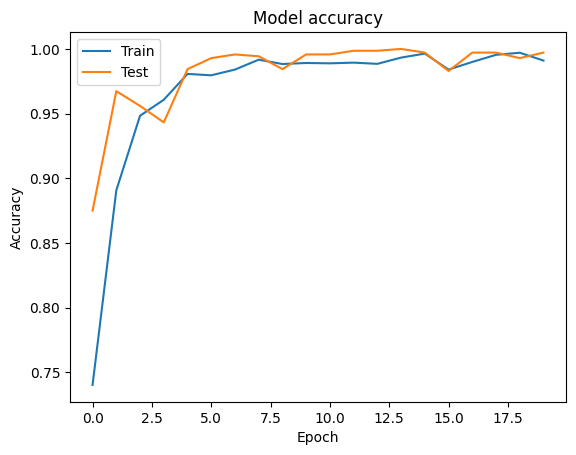

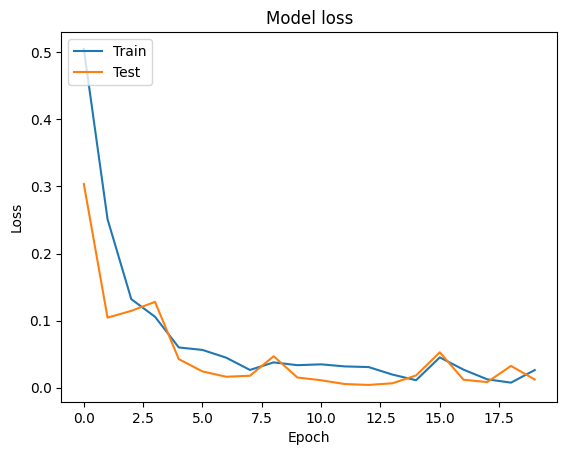

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
# Get the true labels and predictions from the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
print(confusion_matrix(test_generator.classes, y_pred))

# Classification report (precision, recall, F1-score)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

23/23 [==============================] - 2s 89ms/step
[[453   0]
 [262   0]]
              precision    recall  f1-score   support

   def_front       0.63      1.00      0.78       453
    ok_front       0.00      0.00      0.00       262

    accuracy                           0.63       715
   macro avg       0.32      0.50      0.39       715
weighted avg       0.40      0.63      0.49       715



/Users/javie/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javie/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javie/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

The first Classification report (precision, recall, F1-score) failed because my Testing Data is imbalanced! 
Class 0 with 453 samples, has significantly more samples than the other Class 1 with 262 samples. 
This imbalance can cause metrics like precision and recall to be undefined for the minority class, particularly if the model doesn’t predict any samples for that class.


In [11]:
print(Counter(test_generator.classes))

Counter({0: 453, 1: 262})


Let's pass Class Weights. This time I will also add an "early stop" option to avoid taking a lot of computation time.(First iteration took 42 minutes!)
I will also export some .logs for tensorboard to try to make my Neural Network more Visually attractive.

### Visualize the Model with Tensor Board:

The above Network Representation is showing Backend Operations. I will run again the model compilation setting profile_batch=0, to focus on the essential model layers instead of all the training process! 

As the model stopped now very early (4 epochs), I will setup the early stop patience at 3.

In [38]:
# Let's assign class weights to balance the data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert class_weights into a dictionary format
class_weights = dict(enumerate(class_weights))

# Set up TensorBoard log directory and exclude backend operations to plot the general Neural Network architecture in Tensor Board
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, profile_batch=0)

# Configure EarlyStopping: Stop training if val_loss doesn't improve for 3 consecutive epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights, TensorBoard, and EarlyStopping. I will now use 14 epochs as a limit (might finish earlier)
model.fit(train_generator,
          epochs=14,
          class_weight=class_weights,
          validation_data=test_generator,
          callbacks=[tensorboard_callback, early_stop_callback])

# Print the model summary to check the architecture
model.summary()

Epoch 1/14
234/234 [==============================] - 91s 387ms/step - loss: 0.0215 - accuracy: 0.9927 - val_loss: 0.0084 - val_accuracy: 0.9972
Epoch 2/14
234/234 [==============================] - 89s 380ms/step - loss: 0.0081 - accuracy: 0.9965 - val_loss: 0.0033 - val_accuracy: 0.9986
Epoch 3/14
234/234 [==============================] - 89s 381ms/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.0063 - val_accuracy: 0.9986
Epoch 4/14
234/234 [==============================] - 89s 380ms/step - loss: 0.0133 - accuracy: 0.9949 - val_loss: 0.0204 - val_accuracy: 0.9916
Epoch 5/14
234/234 [==============================] - 89s 382ms/step - loss: 0.0288 - accuracy: 0.9902 - val_loss: 0.0092 - val_accuracy: 0.9958
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                         

Let's visualize the network using Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./logs


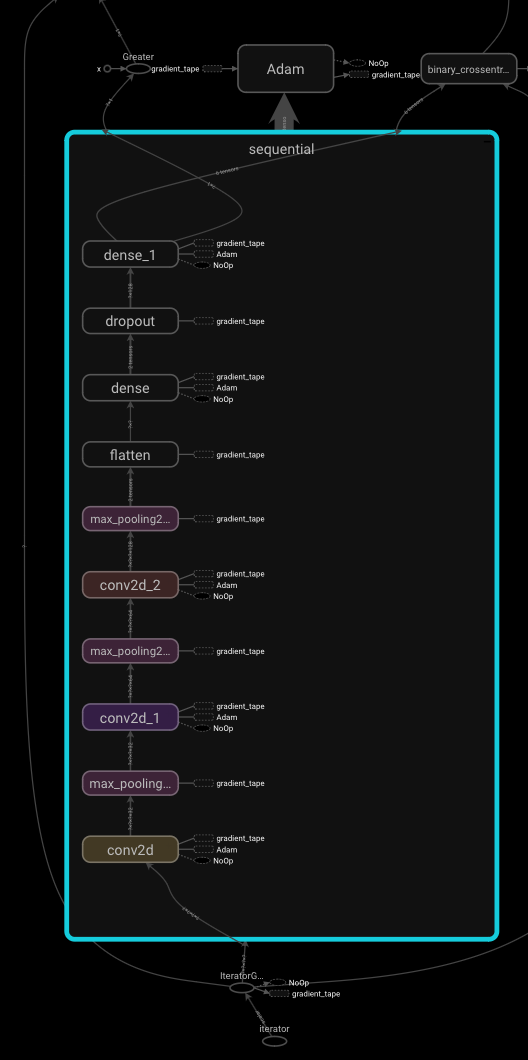 
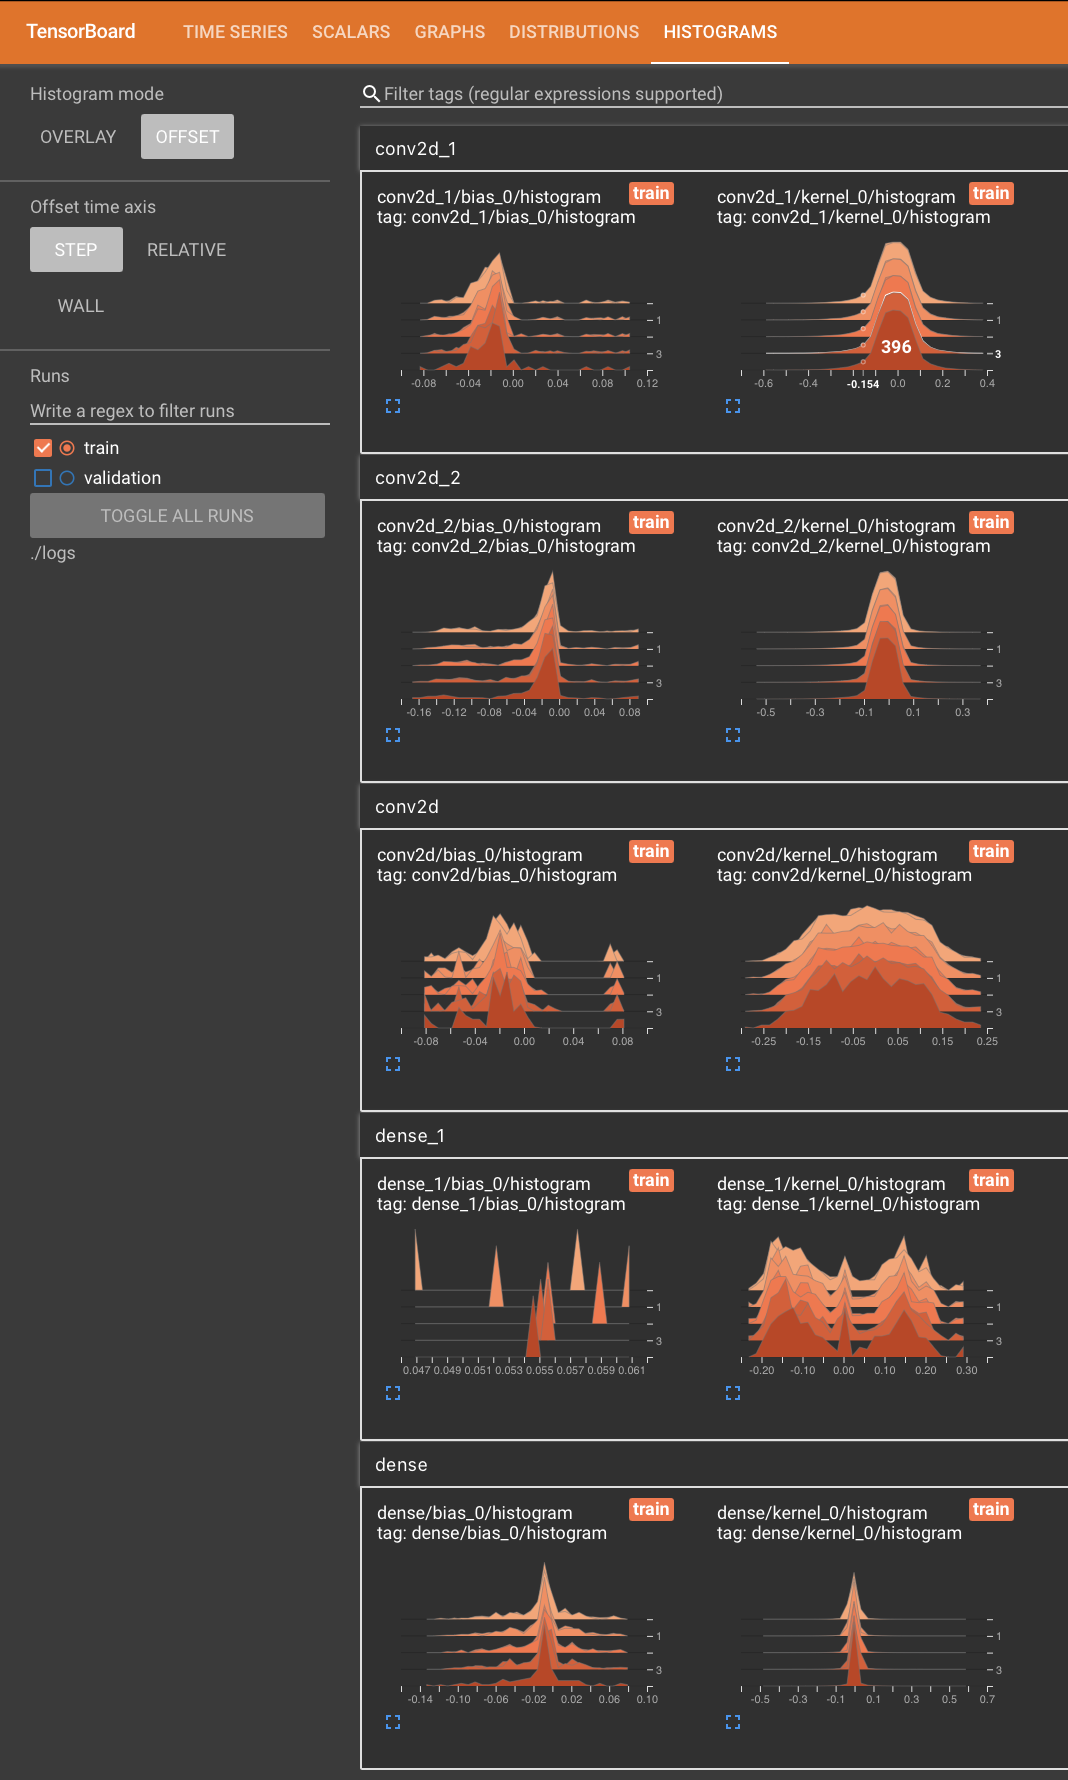

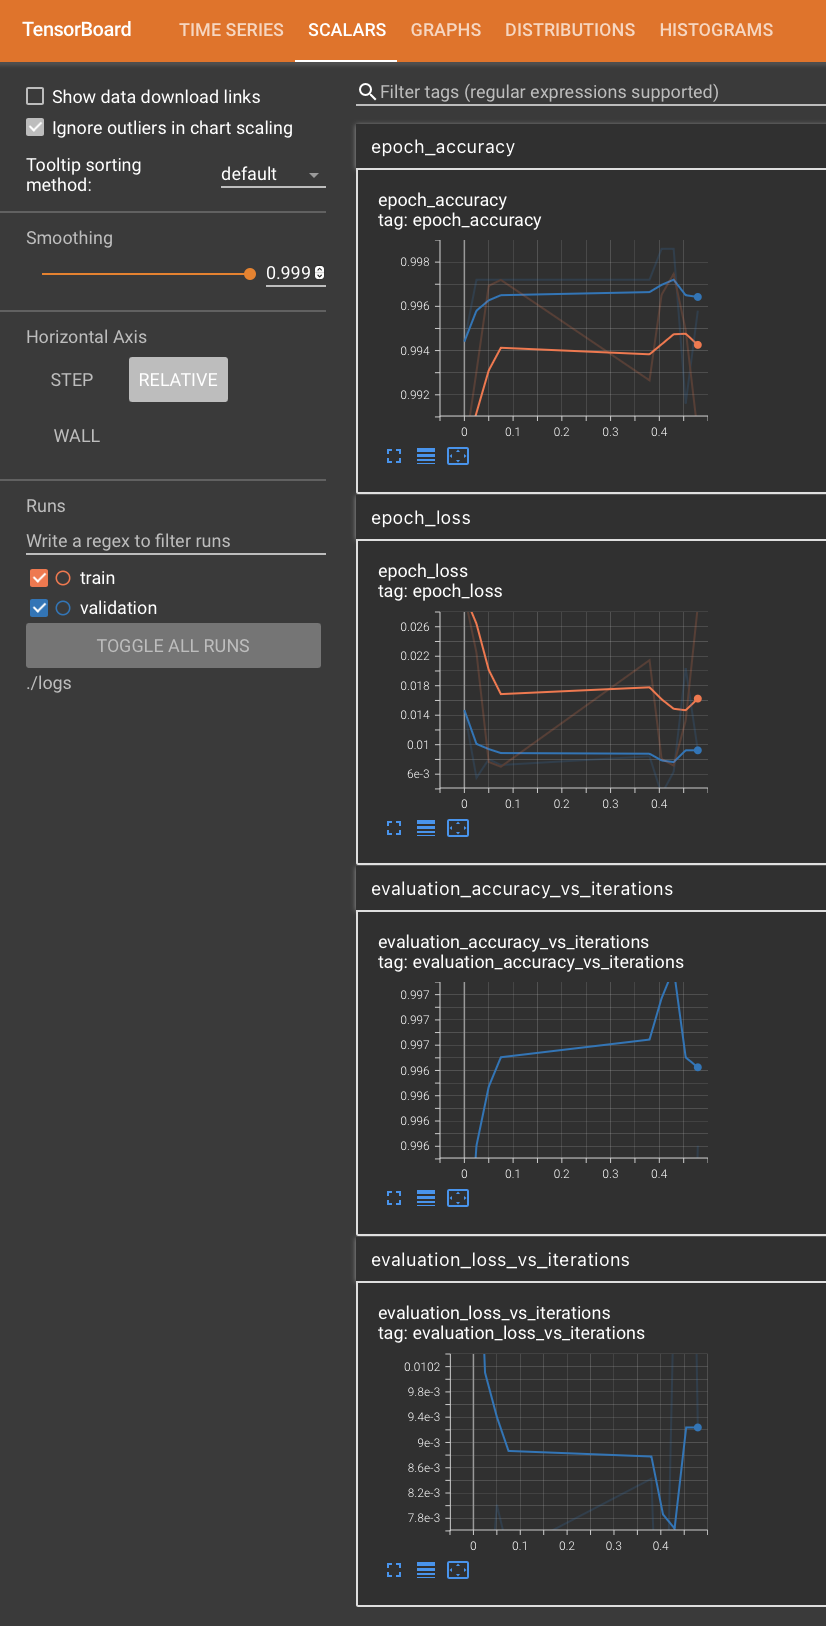

In [40]:
# Evaluate the model on the test data (test_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

23/23 [==============================] - 2s 90ms/step - loss: 0.0033 - accuracy: 0.9986
Test Loss: 0.0032921270467340946
Test Accuracy: 0.9986013770103455


## Again... it looks good in Training and Validation... Lets try it in TESTING!

23/23 [==============================] - 2s 91ms/step


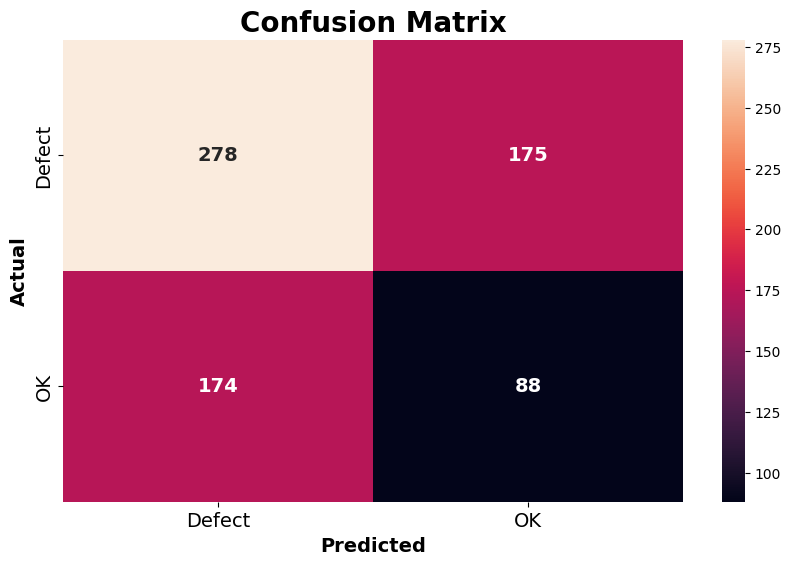

In [46]:
# Get predicted probabilities from the model
pred_probability = model.predict(test_generator)  # Assuming test_set is your test generator

# Convert probabilities to binary predictions (threshold at 0.5)
predictions = pred_probability > 0.5

# Plot the confusion matrix
plt.figure(figsize=(10,6))
plt.title("Confusion Matrix", size=20, weight='bold')
sns.heatmap(
    confusion_matrix(test_generator.classes, predictions),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['Defect', 'OK'],
    yticklabels=['Defect', 'OK']
)
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

## Again! My model is working ok in Training, but not in Testing!  Acuracy is below 63%!

In [47]:
# Get predictions from the model
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Assuming it's a multi-class problem, use argmax

# Print confusion matrix
print(confusion_matrix(test_generator.classes, y_pred))

# Print classification report
print(classification_report(test_generator.classes, y_pred))

23/23 [==============================] - 2s 89ms/step
[[453   0]
 [262   0]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.78       453
           1       0.00      0.00      0.00       262

    accuracy                           0.63       715
   macro avg       0.32      0.50      0.39       715
weighted avg       0.40      0.63      0.49       715



/Users/javie/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javie/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javie/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

### My model seems to be overfitting!

## Lets see if Transfer Learning can help to reduce Overfitting


Lets Load  a model pre-trained on a large dataset like ImageNet, using MobileNetV2

In [49]:
# Load the pre-trained MobileNetV2 model without the top (output) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers in the base model (so they won't be retrained)
base_model.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


Lets add some layers specific to my application:

In [50]:
# Add custom layers on top of the pre-trained base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global pooling layer
x = Dense(128, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

Lets Compile and Train the model

In [52]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the training data and validate on the test data
model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
234/234 [==============================] - 41s 170ms/step - loss: 0.1360 - accuracy: 0.9537 - val_loss: 0.0543 - val_accuracy: 0.9916
Epoch 2/5
234/234 [==============================] - 40s 172ms/step - loss: 0.0399 - accuracy: 0.9907 - val_loss: 0.0335 - val_accuracy: 0.9916
Epoch 3/5
234/234 [==============================] - 42s 178ms/step - loss: 0.0353 - accuracy: 0.9902 - val_loss: 0.0252 - val_accuracy: 0.9930
Epoch 4/5
234/234 [==============================] - 42s 182ms/step - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.0217 - val_accuracy: 0.9944
Epoch 5/5
234/234 [==============================] - 43s 185ms/step - loss: 0.0197 - accuracy: 0.9947 - val_loss: 0.0177 - val_accuracy: 0.9944


In [55]:
# Unfreeze some of the pre-trained layers
base_model.trainable = True

# Recompile the model (with a lower learning rate for fine-tuning) using the legacy Adam optimizer
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
234/234 [==============================] - 204s 863ms/step - loss: 0.1232 - accuracy: 0.9713 - val_loss: 0.3972 - val_accuracy: 0.8741
Epoch 2/10
234/234 [==============================] - 200s 855ms/step - loss: 0.0354 - accuracy: 0.9897 - val_loss: 1.0427 - val_accuracy: 0.7706
Epoch 3/10
234/234 [==============================] - 1321s 6s/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 1.9140 - val_accuracy: 0.6825
Epoch 4/10
234/234 [==============================] - 196s 836ms/step - loss: 0.0114 - accuracy: 0.9956 - val_loss: 3.3879 - val_accuracy: 0.6098
Epoch 5/10
234/234 [==============================] - 201s 857ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 4.2479 - val_accuracy: 0.5720
Epoch 6/10
234/234 [==============================] - 194s 831ms/step - loss: 0.0037 - accuracy: 0.9983 - val_loss: 4.2010 - val_accuracy: 0.5664
Epoch 7/10
234/234 [==============================] - 195s 832ms/step - loss: 0.0033 - accuracy: 0.9984 - val_loss: 4.1467 - v

### Now my Model is overfitting!!  I can see a clear difference between training and Validation.
#### I will go back to basic model training and Hyperparameter tunning (without Transfer learning!)

# THIRD MODEL: 
## My initial 2 models were too complex, 
### Let's Change the Model Architecture for a Simpler model design


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 64)        0

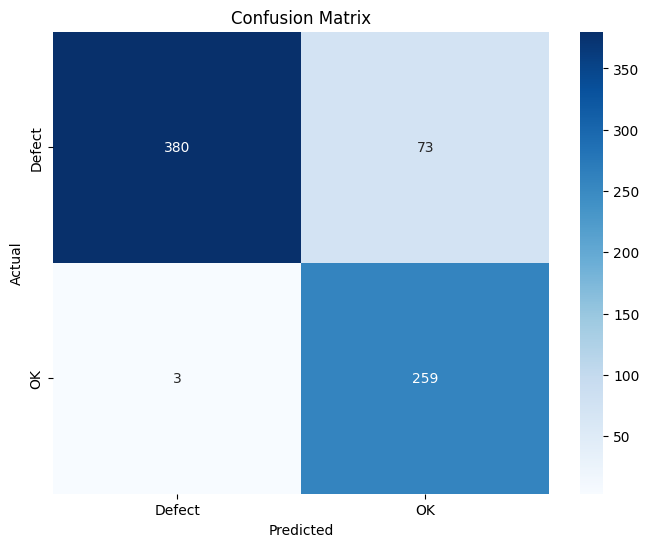

              precision    recall  f1-score   support

      Defect       0.99      0.84      0.91       453
          OK       0.78      0.99      0.87       262

    accuracy                           0.89       715
   macro avg       0.89      0.91      0.89       715
weighted avg       0.91      0.89      0.90       715



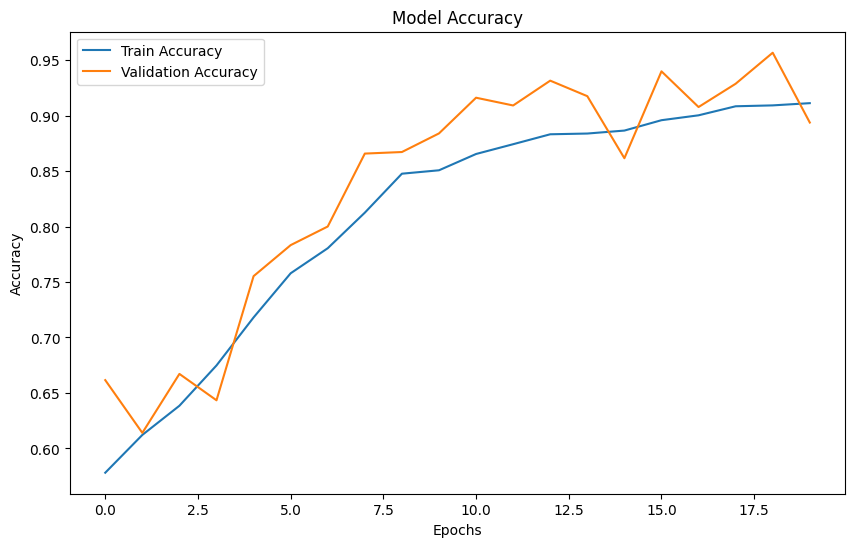

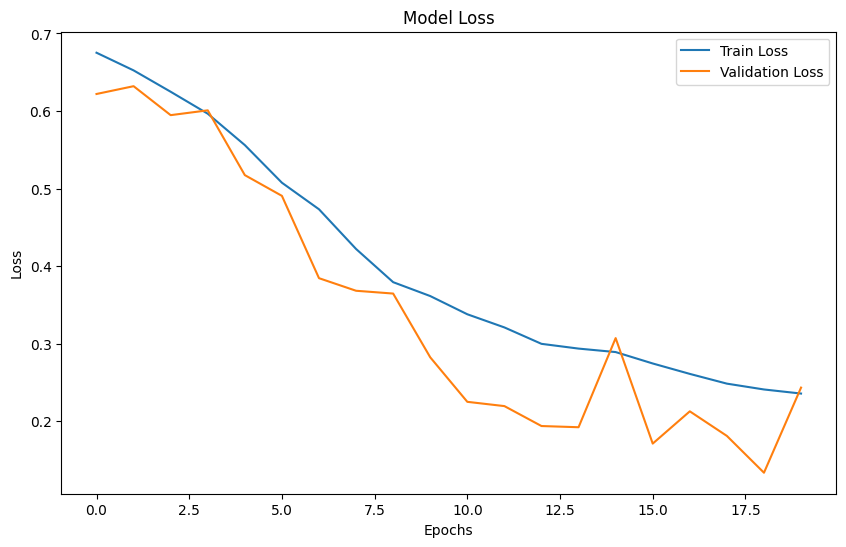

In [88]:
# Clear any previous sessions
tf.keras.backend.clear_session()

# Define image shape (replace this with your actual image dimensions)
image_shape = (300, 300, 3)

# Define Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(units=224, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the Model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Summarize the Model
model.summary()

# Data Preparation: ImageDataGenerator for training with augmentation and testing without augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_dir = "Pictures/train"  # Path to your training data directory
test_dir = "Pictures/test"    # Path to your testing data directory

# Load training data with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=True  # Randomize the selection of images
)

# Load testing data without augmentation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Don't shuffle test data for consistent evaluation
)

# EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model (20 epochs with EarlyStopping)
history = model.fit(
    train_generator,
    epochs=20,  # Training for 20 epochs
    validation_data=test_generator,
    callbacks=[early_stop]  # Adding early stopping to halt training early if needed
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict on test data
preds = model.predict(test_generator)
preds = (preds > 0.5).astype(int)  # Convert probabilities to binary output

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Defect', 'OK'], yticklabels=['Defect', 'OK'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(test_generator.classes, preds, target_names=['Defect', 'OK']))

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Finally Improving !!! 89% Accuracy!
It seems that with a simpler model the acuracy will be better. Now let's see if we can improve it with Hyper parameter Tunning


# Hyper parameter tunning



### Use of Keras-Tuner

In [85]:
#!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 129 kB 801 kB/s eta 0:00:01


Trial 10 Complete [00h 03m 56s]
val_accuracy: 0.6349650621414185

Best val_accuracy So Far: 0.988811194896698
Total elapsed time: 01h 33m 03s

The optimal number of filters for the first Conv2D layer is 16, 
for the second Conv2D layer is 128, 
for the third Conv2D layer is 256.
The optimal number of units in the Dense layer is 512.
The optimal dropout rate is 0.30000000000000004.
The optimal learning rate is 9.878314341240697e-05.

Epoch 1/20
234/234 [==============================] - 66s 281ms/step - loss: 0.6809 - accuracy: 0.5656 - val_loss: 0.6265 - val_accuracy: 0.6755
Epoch 2/20
234/234 [==============================] - 66s 281ms/step - loss: 0.6231 - accuracy: 0.6537 - val_loss: 0.5670 - val_accuracy: 0.6979
Epoch 3/20
234/234 [==============================] - 66s 282ms/step - loss: 0.5410 - accuracy: 0.7241 - val_loss: 0.3896 - val_accuracy: 0.8895
Epoch 4/20
234/234 [==============================] - 66s 280ms/step - loss: 0.4228 - accuracy: 0.8174 - val_loss: 0.2896 - val_

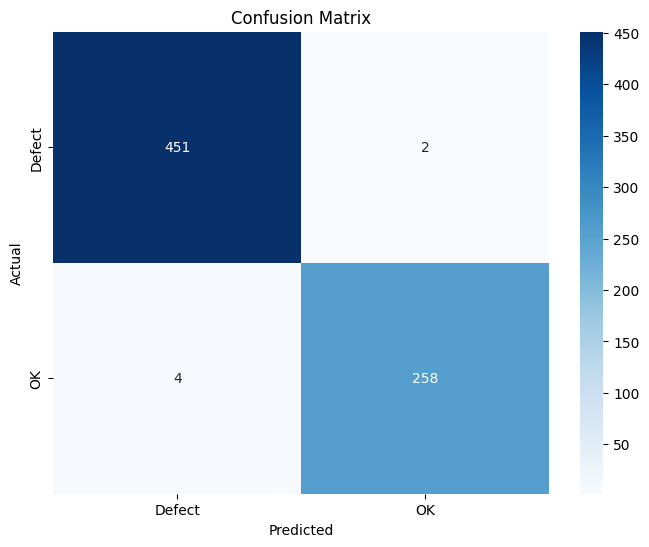

              precision    recall  f1-score   support

      Defect       0.99      1.00      0.99       453
          OK       0.99      0.98      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



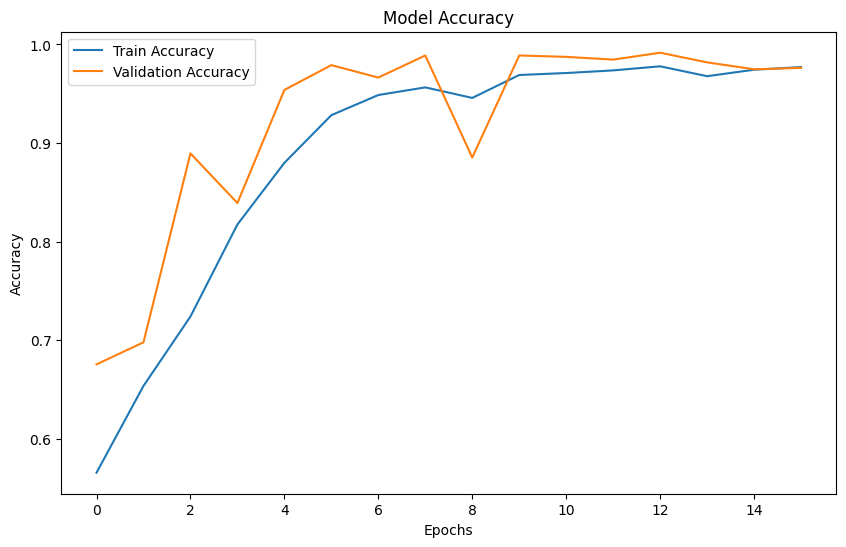

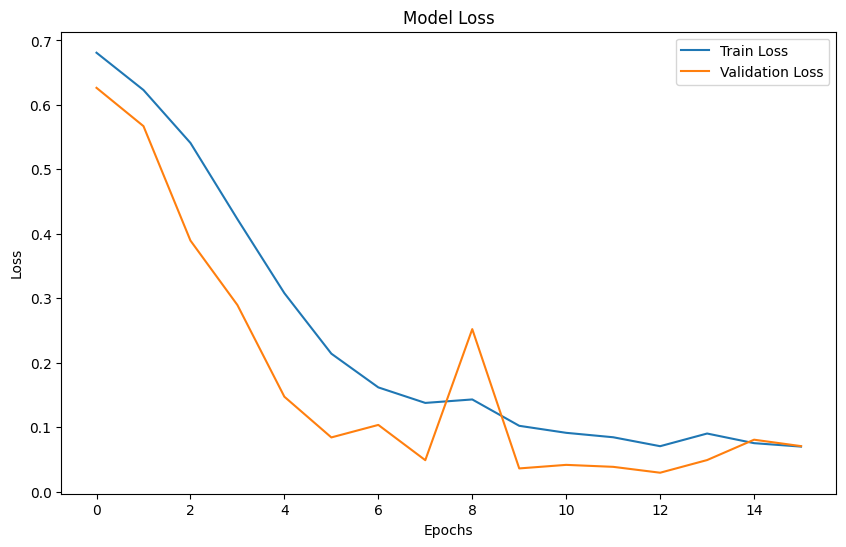

In [89]:

# Define the model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Tune the number of filters for Conv2D layers
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16),
                     kernel_size=(7,7),
                     strides=2,
                     input_shape=(300, 300, 3),
                     activation='relu',
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=hp.Int('filters_3', min_value=64, max_value=256, step=64),
                     kernel_size=(3,3),
                     activation='relu',
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())

    # Tune number of units in Dense layer
    model.add(Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))

    # Tune dropout rate
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=1, activation='sigmoid'))

    # Tune the learning rate
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')

    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner using Bayesian Optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # 10 different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to repeat each trial
    directory='my_dir',
    project_name='image_classification_bayesian'
)

# Use again the paths for training and testing directories
train_dir = "Pictures/train"
test_dir = "Pictures/test"

# Data Preparation: ImageDataGenerator for training pictures with augmentation and testing without augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# EarlyStopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run the hyperparameter search using the Bayesian optimization tuner
tuner.search(train_generator, validation_data=test_generator, epochs=10, callbacks=[early_stop])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters for the first Conv2D layer is {best_hps.get('filters_1')},
for the second Conv2D layer is {best_hps.get('filters_2')},
for the third Conv2D layer is {best_hps.get('filters_3')}.
The optimal number of units in the Dense layer is {best_hps.get('dense_units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the best model using the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,  # Train for 20 epochs with the best hyperparameters
    callbacks=[early_stop]
)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict on test data
preds = best_model.predict(test_generator)
preds = (preds > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Defect', 'OK'], yticklabels=['Defect', 'OK'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(test_generator.classes, preds, target_names=['Defect', 'OK']))

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 99% Accuracy!

Great I will save the model to export it and do some trials later with real Pictures and compara also with Transfer Learning

# Visualization of the Model Working on real pictures!

In [93]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 54.8 MB 1.6 MB/s eta 0:00:01


I will do a random selection of 5 good parts and 5 defective parts

In [15]:
import os
import random

# Directories for images
ok_dir = 'Pictures/test/ok_front'
def_dir = 'Pictures/test/def_front'

# Get all images in each directory
ok_images = os.listdir(ok_dir)
def_images = os.listdir(def_dir)

# Randomly select 5 images from each category
random_ok_images = random.sample(ok_images, 5)
random_def_images = random.sample(def_images, 5)

# Create the full paths for the selected images
random_ok_images_paths = [os.path.join(ok_dir, img) for img in random_ok_images]
random_def_images_paths = [os.path.join(def_dir, img) for img in random_def_images]

# Combine both lists
test_cases = random_ok_images_paths + random_def_images_paths

# Display the selected cases
print("All selected images:", test_cases[0:5])
print(test_cases[5:10])

All selected images: ['Pictures/test/ok_front/cast_ok_0_5805.jpeg', 'Pictures/test/ok_front/cast_ok_0_7611.jpeg', 'Pictures/test/ok_front/cast_ok_0_2694.jpeg', 'Pictures/test/ok_front/cast_ok_0_45.jpeg', 'Pictures/test/ok_front/cast_ok_0_1426.jpeg']
['Pictures/test/def_front/new__0_2055.jpeg', 'Pictures/test/def_front/cast_def_0_1414.jpeg', 'Pictures/test/def_front/cast_def_0_4198.jpeg', 'Pictures/test/def_front/new__0_3299.jpeg', 'Pictures/test/def_front/cast_def_0_1191.jpeg']


Now let's plot the images with their corresponding Real Value (Defective or OK) and the Predicted Value.

1/1 [==============================] - 0s 16ms/step


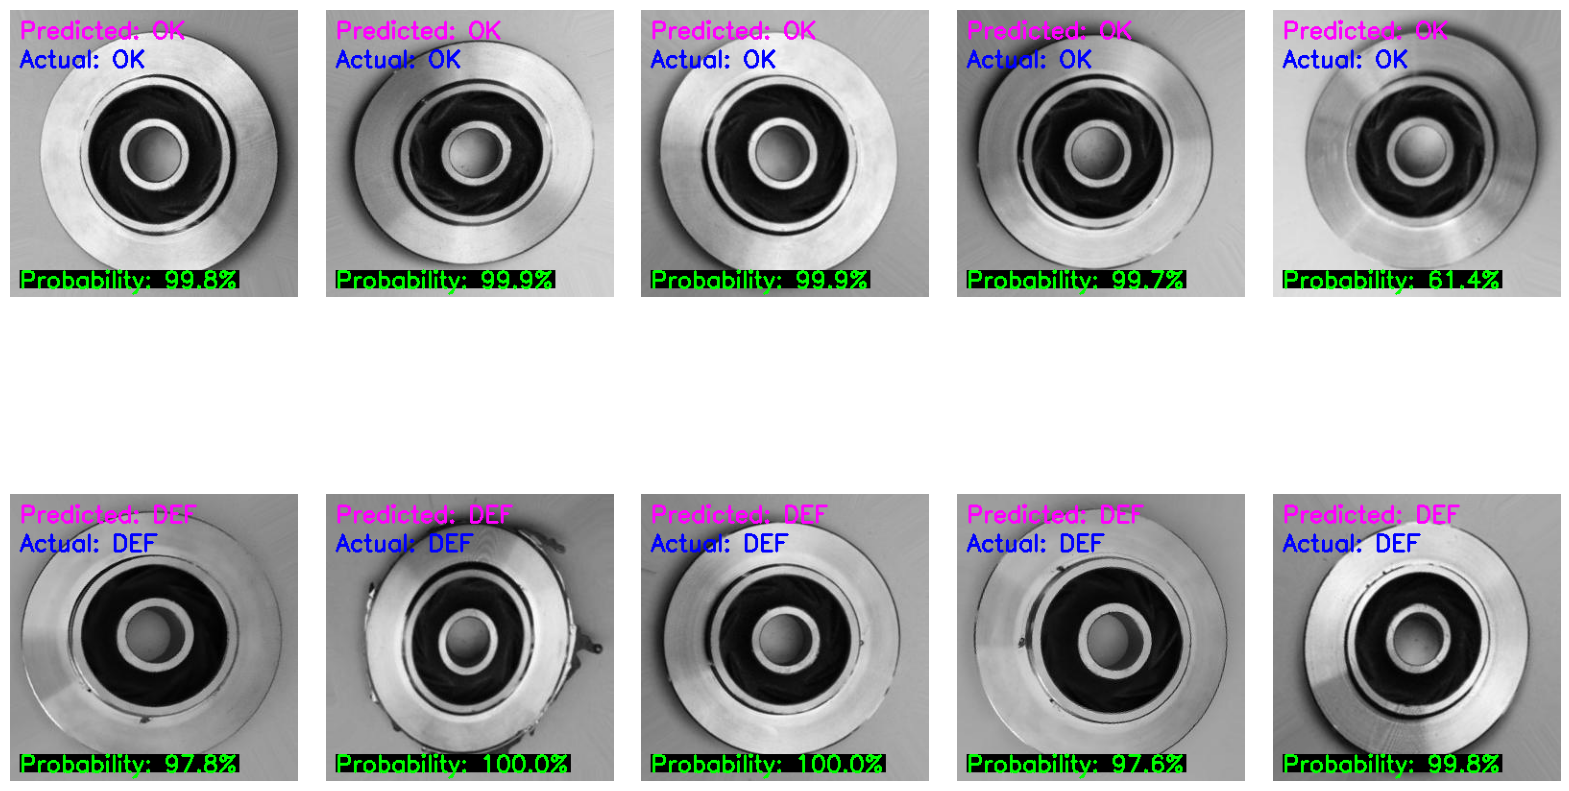

In [55]:
# Define the image shape (adjust based on your model)
image_shape = (300, 300, 3)

# Display the test images and their predictions
plt.figure(figsize=(20, 12))

# Adjust space between images (wspace and hspace)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(len(test_cases)):
    # Load and preprocess the image
    img_path = test_cases[i]
    img_pred = cv2.imread(img_path)

    # Check if the image was loaded properly
    if img_pred is None:
        print(f"Error loading image at path: {img_path}")
        continue  # Skip this iteration if the image wasn't loaded

    # Resize the image
    img_pred_resized = cv2.resize(img_pred, (image_shape[1], image_shape[0]))  # Resize the image
    img_pred_resized = img_pred_resized / 255.0  # Rescale the pixel values
    img_pred_resized = np.expand_dims(img_pred_resized, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img_pred_resized)

    # Determine predicted label
    predicted_label = "DEF" if prediction < 0.5 else "OK"
    prob = (1 - prediction.sum()) * 100 if prediction < 0.5 else prediction.sum() * 100

    # Prepare the original image for display
    img = cv2.imread(img_path)

    # Get the actual label (OK or DEF)
    actual_label = "OK" if "ok_front" in img_path else "DEF"

    # Set the color for the labels
    label_pink = (255, 0, 255)
    label_blue = (255, 0, 0)

    # Add predicted label and actual label to the image in pink and blue
    cv2.putText(img=img, text=f"Predicted: {predicted_label.upper()}", org=(10, 30),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=label_pink, thickness=2)
    cv2.putText(img=img, text=f"Actual: {actual_label}", org=(10, 60),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=label_blue, thickness=2)

    # Set color for probability: green if above 50%, red if below 50%
    prob_color = (0, 255, 0) if prob >= 50 else (255, 0, 0)

    # Determine the size of the text to create a background rectangle
    (text_width, text_height), _ = cv2.getTextSize(f"Probability: {'{:.1f}'.format(prob)}%", cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)

    # Draw the black rectangle as the background
    cv2.rectangle(img, (10, image_shape[0] - 10 - text_height), (10 + text_width, image_shape[0] - 10), (0, 0, 0), -1)

    # Add the probability text on top of the black rectangle
    cv2.putText(img=img, text=f"Probability: {'{:.1f}'.format(prob)}%", org=(10, image_shape[0] - 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=prob_color, thickness=2)

    # Plot the image with predictions
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')

plt.show()

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      2368      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 128)       18560     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 37, 37, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 18, 18, 256)      

# Test Minimum processing speed of 1 picture by the Trained model (In Seconds)

1/1 [==============================] - 0s 20ms/step
Processing time of 1 Picture: 0.04 seconds ==  38.24 miliseconds
Actual: OK
Predicted: OK
Probability: 99.83%


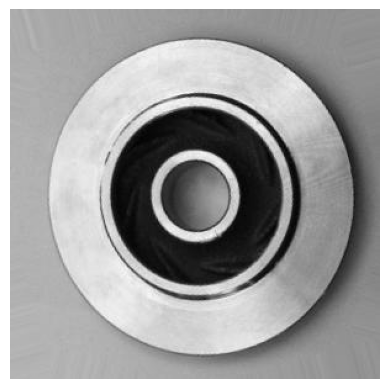

In [62]:
# Test processing speed of Trained model (In Seconds)
import time

# Define the image shape (adjust based on your model)
image_shape = (300, 300, 3)

# Load and preprocess the image
img_path = test_cases[0]
img_pred = cv2.imread(img_path)

# Check if the image was loaded properly
if img_pred is None:
    print(f"Error loading image at path: {img_path}")

# Resize the image
img_pred_resized = cv2.resize(img_pred, (image_shape[1], image_shape[0]))  # Resize the image
img_pred_resized = img_pred_resized / 255.0  # Rescale the pixel values
img_pred_resized = np.expand_dims(img_pred_resized, axis=0)  # Add batch dimension

# Make a prediction
start_time = time.time()
prediction = model.predict(img_pred_resized)
end_time = time.time()

# Determine predicted label
predicted_label = "DEF" if prediction < 0.5 else "OK"
prob = (1 - prediction.sum()) * 100 if prediction < 0.5 else prediction.sum() * 100

# Determine actual label
actual_label = "OK" if "ok_front" in img_path else "DEF"


# Print the processing time in seconds
print(f"Processing time of 1 Picture: {end_time - start_time:.2f} seconds ==  {(end_time - start_time)*1000:.2f} miliseconds")


# Print the prediction and probability
print(f"Actual: {actual_label.upper()}")
print(f"Predicted: {predicted_label.upper()}")
print(f"Probability: {prob:.2f}%")

# Print the picture
plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# This is a great performance! 
### 0.04 secs of processing time, means that the Neural Network could analize up to 90,000 pcs/ hr!

# Conclusion

the model trained from scratch delivered an impressive accuracy of 98%, demonstrating that it was able to learn and generalize the features necessary to classify the metal parts effectively.
 Building the model from scratch allowed me to fully control its architecture and understand the key parameters needed for the task. 
 By doing it this way, I could learn from my mistakes. I started designing a very complex model (that overfitted) and ended up using a simpler model.

 However, despite the programming time, computational cost and time required to train these custom models, this result proves that the model was highly capable of detecting defects and accurately classifying parts.

At the end, the model successfully learned meaningful patterns from the data, making it a reliable solution for this type of classification task.